In [4]:
import pandas as pd
import numpy as np
import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import utils
warnings.filterwarnings('ignore')

In [1]:
%%javascript 
IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }

<IPython.core.display.Javascript object>

In [3]:
uji_data = pd.read_csv('Data\\AllData.csv')

## Preprocess data

In [5]:
uji_data['DATE'] = pd.to_datetime(uji_data['TIMESTAMP'],unit='s').dt.normalize()
uji_data['TIME'] = pd.to_datetime(uji_data['TIMESTAMP'],unit='s').dt.time
uji_data['DAY'] = uji_data['DATE'].dt.dayofweek
uji_data.iloc[:, -11:]

,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP,DATE,TIME,DAY
0,4.864921e+06,2,1,106,2,2,23,1371713733,2013-06-20,07:35:33,3
1,4.864934e+06,2,1,106,2,2,23,1371713691,2013-06-20,07:34:51,3
2,4.864950e+06,2,1,103,2,2,23,1371714095,2013-06-20,07:41:35,3
3,4.864934e+06,2,1,102,2,2,23,1371713807,2013-06-20,07:36:47,3
4,4.864982e+06,0,0,122,2,11,13,1369909710,2013-05-30,10:28:30,3
...,...,...,...,...,...,...,...,...,...,...,...
20281,4.864796e+06,3,2,0,0,0,13,1381156711,2013-10-07,14:38:31,0
20282,4.864792e+06,3,2,0,0,0,13,1381156730,2013-10-07,14:38:50,0
20283,4.864903e+06,0,0,0,0,0,13,1381247781,2013-10-08,15:56:21,1
20284,4.864905e+06,0,0,0,0,0,13,1381247807,2013-10-08,15:56:47,1


## Feature Extraction

In [6]:
def average_building_duration(user_df):
    # group by day, find the duration of each day, return the average
    
    user_df = user_df.sort_values(by='TIMESTAMP', ascending=True)
    user_df = user_df.reset_index()
    
    buildings = user_df['BUILDINGID']
    days = user_df['DATE']
    time = user_df['TIME']
    
    ret_df = pd.DataFrame(columns=['BUILDINGID', 'DURATION'])
    init_duration = datetime.timedelta()
    duration_dict = {building: datetime.timedelta() for building in buildings.unique()}
    day_count = 0
    start = 0
    
    for t in range(user_df.shape[0]):
        if t < user_df.shape[0] - 1:
            assert days[t+1] >= days[t] or time[t+1] >= time[t], datetime.datetime.fromtimestamp(user_df['TIMESTAMP'][t+1]).strftime('%Y-%m-%d %H:%M:%S') + ', ' + days[t+1].strftime('%Y-%m-%d') + ', ' + time[t+1].strftime('%H:%M:%S') + '\n' + datetime.datetime.fromtimestamp(user_df['TIMESTAMP'][t]).strftime('%Y-%m-%d %H:%M:%S') + ', ' + days[t].strftime('%Y-%m-%d') + ', ' + time[t].strftime('%H:%M:%S') + '\n' 
            
        elif t == user_df.shape[0] - 1: # last row
            day_count += 1
            duration_dict[buildings[t]] = duration_dict.get(buildings[t], init_duration) + utils.time_difference(time[t], time[start])

            for bldng in duration_dict:
                # calculate average over all visiting days and add to returning data frame
                ret_df = ret_df.append({'BUILDINGID': bldng, 'DURATION': duration_dict[bldng] / day_count}, ignore_index=True) 
            
        elif days[t+1] != days[t]: # change day
            day_count += 1
            duration_dict[buildings[t]] = duration_dict.get(buildings[t], init_duration) + utils.time_difference(time[t], time[start])
            start = t+1
            
        elif buildings[t+1] != buildings[t]: # change of building
            duration_dict[buildings[t]] = duration_dict.get(buildings[t], init_duration) + utils.time_difference(time[t], time[start])
            start = t+1
            
    return ret_df.set_index('BUILDINGID').T

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize

def translate_linger_centers_textual(user_df):
    centers = []
    
    for _, centroid in user_df.iterrows():
        centers += ["B{}F{}S{}".format(int(centroid.BUILDINGID), int(centroid.FLOOR), int(centroid.SPACEID))]*int(centroid.pts_count)
    
    return " ".join(centers)

# perceive cluster centres as words, normalize vectors and use euclidean
# clusters centres of where user tends to linger
def cluster_centers_vectors(user_df):
    corpus = user_df.groupby('USERID').apply(translate_linger_centers_textual)
    vectorizer = TfidfVectorizer()
    X = normalize(vectorizer.fit_transform(corpus))
    X_df = pd.DataFrame.sparse.from_spmatrix(X) 
    words = vectorizer.get_feature_names()
    X_df = X_df.rename(lambda x: words[x], axis='columns')
    return X_df.fillna(0)

In [10]:
# unique number of days of visit to campus
f1 = uji_data.groupby('USERID')['DATE'].apply(lambda x: len(x.dt.normalize().unique()))
f1 = f1.rename("Days of visit")

# average uji_data of visit to campus
f2 = uji_data.groupby(['USERID', 'DATE'])['TIME'].apply(lambda x: utils.time_difference(max(x),min(x))).groupby('USERID').apply(lambda x: x.mean())
f2 = f2.rename("Average Duration of visit")

# average duration of staying in a building in different days
f3 = uji_data.groupby('USERID').apply(average_building_duration)
f3.index = [x[0] for x in f3.index.tolist()]
f3.replace({pd.NaT: datetime.timedelta()}, inplace=True)
f3 = f3.rename(lambda x: "Average Duration in Building " + str(x), axis='columns')

# the median time of day when user visits campus
f4 = uji_data.groupby(['USERID', 'DATE'])['TIME'].apply(utils.datetime_median).groupby('USERID').apply(utils.datetime_median)
f4 = f4.rename("Median Time of visit")

# the days when user visits campus 
f5 = uji_data.groupby(['USERID','DAY'])['DATE'].apply(lambda x: len(x.dt.normalize().unique())).unstack()
f5.replace({np.nan: 0}, inplace=True)
f5 = f5.rename(lambda x: "Visit Count on Day " + str(x), axis='columns')

# clusters centres of where user tends to linger
linger_centers = pd.read_csv('Outputs\\4\\dbscan_all_users.csv')
f6 = cluster_centers_vectors(linger_centers)

In [11]:
X = pd.concat([f1, f2, f3, f4, f5, f6], axis=1)
X.iloc[:, 1:5] = X.iloc[:, 1:5] / pd.to_timedelta(1, unit='D')
X.iloc[:, 5] = X.iloc[:, 5].apply(lambda a: a.hour + a.minute/60.0)
X.iloc[:, 7:] = X.iloc[:, 7:].fillna(0)
X

,Days of visit,Average Duration of visit,Average Duration in Building 0,Average Duration in Building 1,Average Duration in Building 2,Median Time of visit,Visit Count on Day 0,Visit Count on Day 1,Visit Count on Day 2,Visit Count on Day 3,...,b2f3s214,b2f3s215,b2f3s216,b2f3s223,b2f3s230,b2f3s236,b2f3s241,b2f3s247,b2f4s129,b2f4s141
0,9,0.108666,0.322558,0.000000,0.000000,11.066667,1.0,3.0,0.0,3.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2,0.121065,0.058808,0.000000,0.000000,15.716667,1.0,0.0,1.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1,0.093264,0.000000,0.000000,0.093264,8.466667,0.0,0.0,0.0,1.0,...,0.285714,0.285714,0.285714,0.285714,0.285714,0.285714,0.285714,0.285714,0.000000,0.000000
3,1,0.006875,0.000000,0.000000,0.006875,9.266667,0.0,0.0,0.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1,0.031863,0.000000,0.031863,0.000000,13.916667,0.0,0.0,0.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.707107,0.707107
5,1,0.106782,0.000000,0.000000,0.106782,9.483333,0.0,0.0,0.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,1,0.083495,0.000000,0.000000,0.083495,8.016667,0.0,0.0,0.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,1,0.129734,0.000000,0.000000,0.129734,9.516667,0.0,0.0,0.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,1,0.082743,0.000000,0.000000,0.082743,9.333333,0.0,0.0,0.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,1,0.108692,0.000000,0.108692,0.000000,9.433333,0.0,0.0,0.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [12]:
from sklearn import preprocessing

# Normalize values for training 
# - prevent exessive effect of features with smaller variance
# Normalize > standardization in the sense that it does not make any
# assumptions abt the distribution of the features. 
# Even of gaussian, small dataset means inaccuracy or bias in estimating mean and s.d.
scaler = preprocessing.MinMaxScaler()
scaled_X = X.copy()
# only from f1 to f4, since f5 is binned and f6 is already normalized
scaled_X.iloc[:, 0:11] = scaler.fit_transform(scaled_X.iloc[:, 0:11])
scaled_X

,Days of visit,Average Duration of visit,Average Duration in Building 0,Average Duration in Building 1,Average Duration in Building 2,Median Time of visit,Visit Count on Day 0,Visit Count on Day 1,Visit Count on Day 2,Visit Count on Day 3,...,b2f3s214,b2f3s215,b2f3s216,b2f3s223,b2f3s230,b2f3s236,b2f3s241,b2f3s247,b2f4s129,b2f4s141
0,1.000,0.828524,1.000000,0.000000,0.000000,0.493648,1.0,1.000000,0.0,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.125,0.929439,0.182317,0.000000,0.000000,1.000000,1.0,0.000000,1.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000,0.703156,0.000000,0.000000,0.718887,0.210526,0.0,0.000000,0.0,0.333333,...,0.285714,0.285714,0.285714,0.285714,0.285714,0.285714,0.285714,0.285714,0.000000,0.000000
3,0.000,0.000000,0.000000,0.000000,0.052993,0.297641,0.0,0.000000,0.0,0.333333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000,0.203391,0.000000,0.293153,0.000000,0.803993,0.0,0.000000,0.0,0.333333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.707107,0.707107
5,0.000,0.813189,0.000000,0.000000,0.823089,0.321234,0.0,0.000000,0.0,0.333333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000,0.623646,0.000000,0.000000,0.643590,0.161525,0.0,0.000000,0.0,0.333333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000,1.000000,0.000000,0.000000,1.000000,0.324864,0.0,0.000000,0.0,0.333333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000,0.617522,0.000000,0.000000,0.637791,0.304900,0.0,0.000000,0.0,0.333333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000,0.828733,0.000000,1.000000,0.000000,0.315789,0.0,0.000000,0.0,0.333333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Clustering 

In [13]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from BisectingKMeans import BisectingKMeans

In [14]:
from sklearn.metrics import silhouette_score

clustering_algo = ["K-Means", "Bisecting K-Means", "Agglomerative"]
agglo_linkages = ["ward", "complete", "average", "single"]
models = [KMeans(), BisectingKMeans(), AgglomerativeClustering()]
evaluation_df = pd.DataFrame(columns=['Algorithm', 'n', 'Agglomerative_Linkage', 'Inertia', 'Sillhoette'])
clustering_results = pd.DataFrame(columns=[i for i in range(X.shape[0])])

def compute_inertia(agglo_model, X):
    assert agglo_model.labels_ is not None
    centroids = compute_centres(X, agglo_model.labels_, agglo_model.n_clusters_)
    inertia = 0

    for l in range(agglo_model.n_clusters_):
        centroid = centroids[l, :]
        label_x = X.iloc[np.where(agglo_model.labels_ == l)]
        inertia += np.sum(np.sum(np.square(label_x - centroid)))
                                    
    return inertia
    
def compute_centres(X, labels, n_clusters):
    assert labels is not None
    centroids = np.zeros((n_clusters,X.shape[1]))

    for l in range(n_clusters):
        label_x = X.iloc[np.where(labels == l)]
        centroid = np.mean(label_x, 0)
        centroids[l,:] = centroid
    
    return centroids

def fit_eval_to_dict(model, data, is_agglo=False):
    eval_dict = dict()
    model.fit(data)
    if is_agglo:
        eval_dict['Inertia'] = compute_inertia(model, data)
    else:
        eval_dict['Inertia'] = model.inertia_
    eval_dict['Sillhoette'] = silhouette_score(data, model.labels_)
    return eval_dict

for n in range(2, 10):
    for i in range(len(clustering_algo)):
        model = models[i]
        model.set_params(**{'n_clusters': n})
        if i == len(clustering_algo) - 1: # is agglomerative clustering
            for j in range(len(agglo_linkages)):
                print("Fitting using {} with n={} & linkage={}".format(clustering_algo[i], n, agglo_linkages[j]))
                model.set_params(**{"linkage": agglo_linkages[j]})
                eval_dict = fit_eval_to_dict(model, scaled_X, is_agglo=True)
                eval_dict['Agglomerative_Linkage'] = agglo_linkages[j]
                eval_dict['Algorithm'] = clustering_algo[i]
                eval_dict['n'] = n
                evaluation_df = evaluation_df.append(eval_dict, ignore_index=True) 
                clustering_results = clustering_results.append(pd.Series(model.labels_), ignore_index=True)
                
                # use results of agglomerative for kmeans
                centroids = compute_centres(scaled_X, model.labels_, model.n_clusters_)
                kmeans_model = KMeans(n_clusters=n, init=centroids)
                eval_dict = fit_eval_to_dict(kmeans_model, scaled_X)
                eval_dict['Agglomerative_Linkage'] = agglo_linkages[j]
                eval_dict['Algorithm'] = clustering_algo[i] + " then K-Means"
                eval_dict['n'] = n
                evaluation_df = evaluation_df.append(eval_dict, ignore_index=True) 
                clustering_results = clustering_results.append(pd.Series(model.labels_), ignore_index=True)
        else:
            print("Fitting using {} with n={}".format(clustering_algo[i], n))
            eval_dict = fit_eval_to_dict(model, scaled_X)
            eval_dict['Algorithm'] = clustering_algo[i]
            eval_dict['n'] = n
            evaluation_df = evaluation_df.append(eval_dict, ignore_index=True) 
            clustering_results = clustering_results.append(pd.Series(model.labels_), ignore_index=True)

Fitting using K-Means with n=2
Fitting using Bisecting K-Means with n=2
Fitting using Agglomerative with n=2 & linkage=ward
Fitting using Agglomerative with n=2 & linkage=complete
Fitting using Agglomerative with n=2 & linkage=average
Fitting using Agglomerative with n=2 & linkage=single
Fitting using K-Means with n=3
Fitting using Bisecting K-Means with n=3
Fitting using Agglomerative with n=3 & linkage=ward
Fitting using Agglomerative with n=3 & linkage=complete
Fitting using Agglomerative with n=3 & linkage=average
Fitting using Agglomerative with n=3 & linkage=single
Fitting using K-Means with n=4
Fitting using Bisecting K-Means with n=4
Fitting using Agglomerative with n=4 & linkage=ward
Fitting using Agglomerative with n=4 & linkage=complete
Fitting using Agglomerative with n=4 & linkage=average
Fitting using Agglomerative with n=4 & linkage=single
Fitting using K-Means with n=5
Fitting using Bisecting K-Means with n=5
Fitting using Agglomerative with n=5 & linkage=ward
Fitting u

## Evaluation 

<AxesSubplot:title={'center':'Sillhouette'}, xlabel='n', ylabel='Sillhoette'>

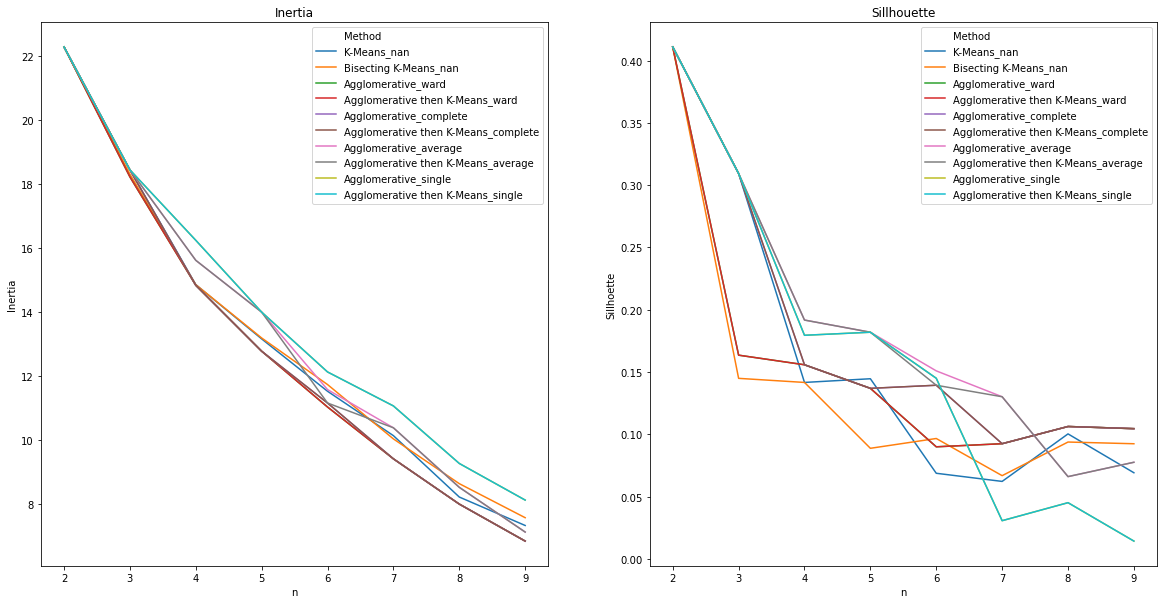

In [15]:
plt.figure(figsize=(20,10))
eval_df_to_plot = evaluation_df.copy()
eval_df_to_plot['Method'] = evaluation_df['Algorithm'] + '_' + evaluation_df['Agglomerative_Linkage'].astype(str)
ax = plt.subplot(1, 2, 1)
ax.set_title("Inertia")
sns.lineplot(data=eval_df_to_plot, x="n", y="Inertia", hue="Method")
ax = plt.subplot(1, 2, 2)
ax.set_title("Sillhouette")
sns.lineplot(data=eval_df_to_plot, x="n", y="Sillhoette", hue="Method")

In [16]:
clustering_results[evaluation_df['n'] == 2]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

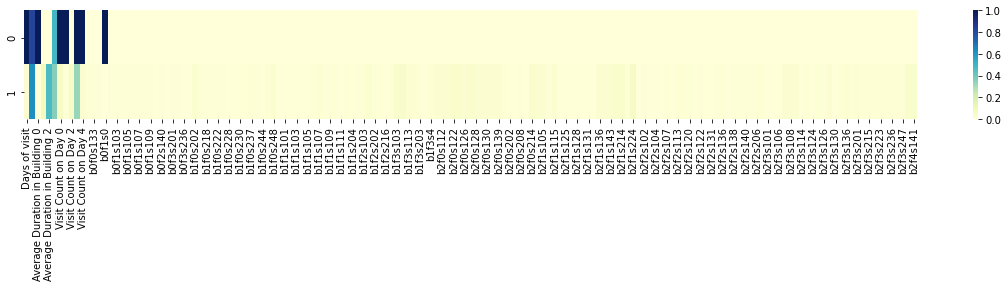

In [17]:
centroids = compute_centres(scaled_X, clustering_results.iloc[0,:], 2)
centroids = pd.DataFrame(centroids)
centroids.columns = X.columns

plt.figure(figsize=(20,2))
sns.heatmap(centroids, cmap="YlGnBu")

## Using network to extract more probable clusters

In [18]:
from itertools import combinations
cluster_network = np.zeros(shape=(scaled_X.shape[0], scaled_X.shape[0]))

for (_, data) in clustering_results.iterrows():
    count = 0
    i = 0
    while count != scaled_X.shape[0]: 
        cluster_pts = data[data == i].index
        for pair in list(combinations(cluster_pts, 2)):
            cluster_network[pair[0], pair[1]] += 1
            cluster_network[pair[1], pair[0]] += 1
        i += 1
        count += cluster_pts.size

In [20]:
np.savetxt('Outputs\\6\\cluster_adj_mat.csv', cluster_network, delimiter=',')

In [21]:
cluster_network = pd.DataFrame(cluster_network)

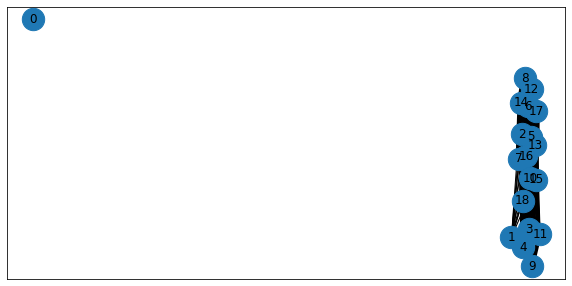

In [24]:
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(10,5))
gr = nx.from_pandas_adjacency(cluster_network)
scaled_weights = [gr[u][v]['weight']/10 for u, v in gr.edges()]
nx.draw_networkx(gr, node_size = 500, with_labels=True, width=scaled_weights)
plt.show()

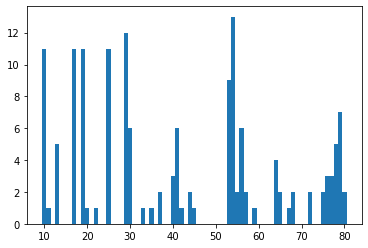

In [25]:
# distribution of weights
weights = [gr[u][v]['weight'] for u, v in gr.edges()]
weights = np.array(weights)
d = np.diff(np.unique(weights)).min()
left = weights.min() - float(d)/2
right = weights.max() + float(d)/2
plt.hist(weights, np.arange(left, right+d, d))
plt.show()

In [26]:
# remove edges when weight less than 70, i.e. remove connections of users if they are clustered in the same group 
# for less than 70 times
mini_gr = gr.copy()
for u, v, w in gr.edges.data('weight'):
    if w < 70:
        mini_gr.remove_edge(u, v)

for c in nx.connected_components(mini_gr):
    print(c)

{0}
{1}
{2, 5, 6, 12, 13, 16, 17}
{3}
{4}
{8, 14, 7}
{9}
{10}
{11}
{15}
{18}


In [27]:
cluster_no = 0
use_label = np.zeros(shape=(X.shape[0],), dtype=int)

for c in nx.connected_components(mini_gr):
    for user in c:
        use_label[user] = cluster_no
    cluster_no += 1

use_label

array([ 0,  1,  2,  3,  4,  2,  2,  5,  5,  6,  7,  8,  2,  2,  5,  9,  2,
        2, 10])

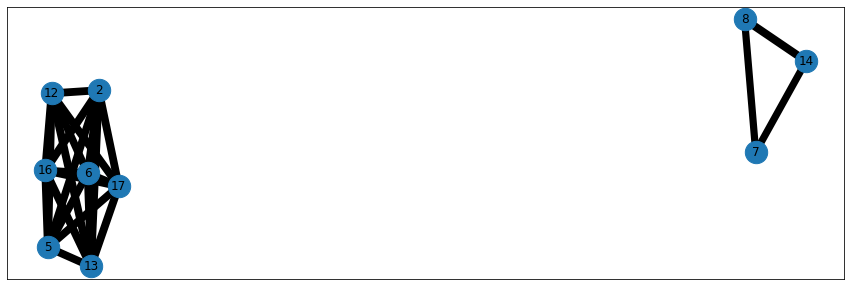

In [28]:
# remove nodes which is not in any cluster 
mini_mini_gr = mini_gr.copy()
for c in nx.connected_components(mini_gr):
    if len(c) == 1:
        for user in c:
            mini_mini_gr.remove_node(user)

plt.figure(figsize=(15,5))
scaled_weights = [mini_mini_gr[u][v]['weight']/10 for u, v in mini_mini_gr.edges()]
nx.draw_networkx(mini_mini_gr, node_size = 500, with_labels=True, width=scaled_weights)
plt.show()

## Cluster Analysis

In [ ]:
compute_intertia

<AxesSubplot:>

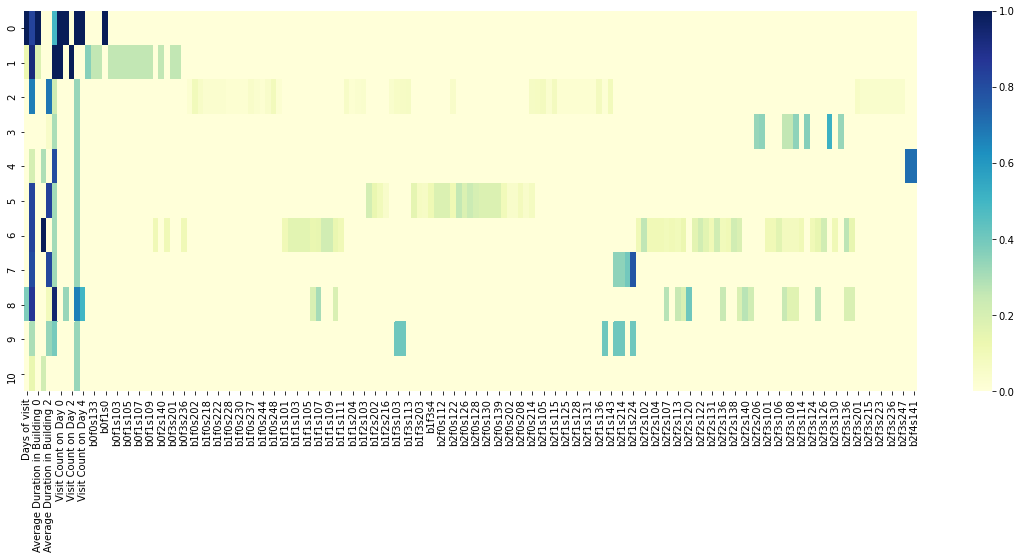

In [32]:
centroids = compute_centres(scaled_X, use_label, len([c for c in nx.connected_components(mini_gr)]))
centroids = pd.DataFrame(centroids)
centroids.columns = X.columns

plt.figure(figsize=(20,7))
sns.heatmap(centroids, cmap="YlGnBu")

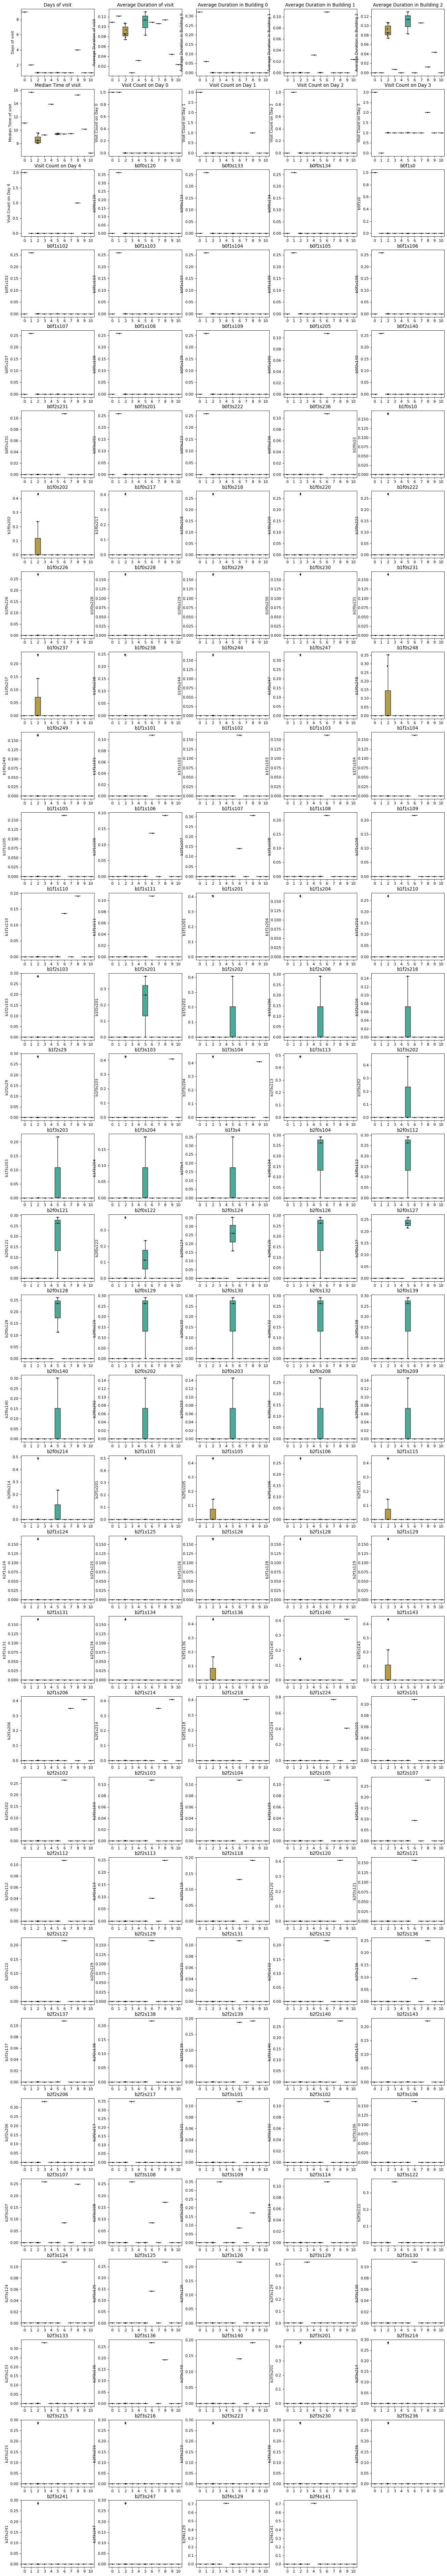

In [29]:
# visualize distribution of variables based on cluster from mini_gr
plt.figure(figsize=(20,124), dpi=80)
i = 1
for name, data in X.iteritems(): # use original data to see distribution, not scaled 
    ax = plt.subplot(32, 5, i)
    sns.boxplot(x=use_label, y=data)
    sns.stripplot(x=use_label, y=data, color='black', size=3, jitter=1)
    ax.set_title(name)
    i += 1